In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils as utils
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensor
import torchvision
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict
import PIL
from PIL import Image, ImageDraw, ImageFont
import cv2

from torchsummary import summary

from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import time
import os

In [6]:
from pathlib import Path
root = Path("image")

## Check the annotation

In [7]:
for _ in root.glob("*"):
    if _.is_dir():
        dir_name = _.name
        for p in _.glob("*"):
            if p.name.split("_")[0] != dir_name:
                print(p)

## Helpers

In [8]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(x[index])
            ax.set_xlabel(y[index], )
            index+=1

    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()

## Hyper-parameters

In [9]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 42

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Datasets

In [10]:
class ImageDataset(Dataset):
    
    def __init__(self, image_path, transforms = None):
        super(ImageDataset, self).__init__()
        
        self.image_path = image_path
        self.classes = []
        self.all_images = []
        self.labels = []
        
        self.transforms = transforms
        
            
        for _ in self.image_path.glob("*"):
            if _.is_dir():
                dir_name = _.name
                self.classes.append(dir_name)
                for p in _.glob("*"):
                    self.all_images.append(p)
        
        
        self.class2index = {b:a for a,b in enumerate(self.classes)}
        self.index2class = {a:b for a,b in enumerate(self.classes)}
        
        random.shuffle(self.all_images)
        
        for p in self.all_images:
            self.labels.append( self.class2index[p.name.split("_")[0]])
            

    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, index):
        
        img = cv2.imread(str(self.all_images[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = self.transforms(image = img)["image"]
        target = torch.tensor(self.labels[index])
        
        return img, target

# class TestDataset(Dataset):
#     def __init__(self,chars, test_image_root, transfroms = None):
        
#         self.chars = chars
#         self.char2index = {char:index for char, index in zip(self.chars, range(len(self.chars)))}
#         self.index2char = {index:char for char, index in zip(self.chars, range(len(self.chars)))}
        
#         self.test_images = list(test_image_root.glob("*.png"))
#         self.transforms = transfroms
        
#     def __len__(self):
#         return len(self.test_images)
    
#     def __getitem__(self, idx):
#         image = Image.open(self.test_images[idx])
#         name = self.test_images[idx].name.split(".")[0]
        
#         if self.transforms:
#             image = self.transforms(image)
        
#         target = self.char2index[name]
#         return image,target

In [11]:
train_transforms =  A.Compose([
                        A.ShiftScaleRotate(interpolation = cv2.INTER_NEAREST),
                        A.OneOf([A.VerticalFlip(p=0.3),
                                 A.HorizontalFlip(p=0.3)
                                ]),
                        A.RandomBrightnessContrast(p=0.5),
                        A.HueSaturationValue(p=0.5),
                        A.Cutout(2, p=0.2, max_h_size = 10, max_w_size = 10),
                        A.ToGray(p=0.2),
                        A.Resize(height = 224, width = 224, p=1),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                ])



test_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensor()
])


dataset = ImageDataset(root, transforms = train_transforms)

train_length = int(len(dataset) * 0.8)
val_length = len(dataset) - train_length

train_dataset, val_dataset = utils.data.random_split(dataset,[train_length, val_length])

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=True)

val_dataloader = DataLoader(dataset = val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=False)

dataset_loader = {"train": train_dataloader, "val": val_dataloader}

In [12]:
image, target = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

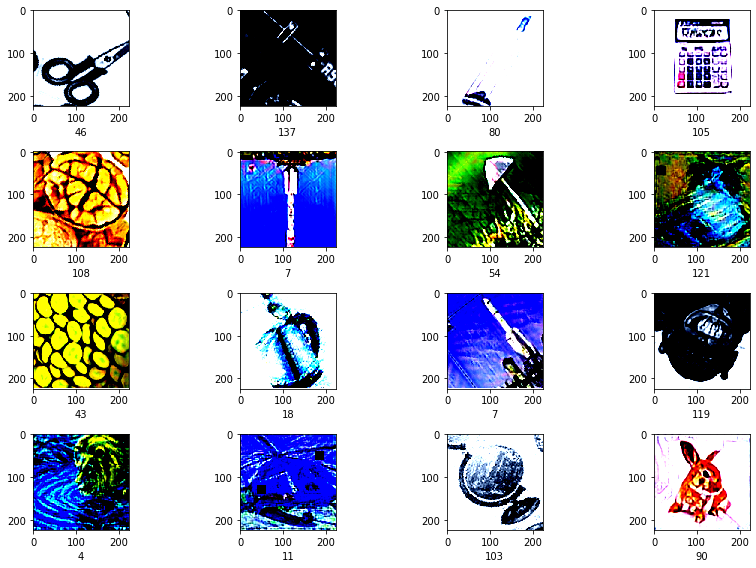

In [13]:
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [14]:
",".join([dataset.index2class[item] for item in target.numpy()])

'剪刀,红绿灯,注射器,计算器,核桃,火箭,蘑菇,猫,药片,水壶,火箭,猴子,狮子,直升机,地球仪,兔子,药片,注射器,鸟,笔记本电脑,窗帘,螃蟹,铁路,锅铲,苍蝇拍,地球仪,摩托车,珍珠,羽毛球,袋鼠,红绿灯,牙刷'

## Model

In [15]:
base_model = torchvision.models.resnet18(pretrained=True)
for index, (name, layer) in enumerate(base_model.named_children()):
    print(index, name, " -> ", layer)
    print("--"* 40)

0 conv1  ->  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------------------------------------------------------------------
1 bn1  ->  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--------------------------------------------------------------------------------
2 relu  ->  ReLU(inplace=True)
--------------------------------------------------------------------------------
3 maxpool  ->  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--------------------------------------------------------------------------------
4 layer1  ->  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64

In [16]:
class GJImageModel(nn.Module):
    def __init__(self, n_classes):
        super(GJImageModel, self).__init__()
        
        self.base_model = torchvision.models.resnet34(pretrained=True)
#         for param in base_model.parameters():
#             param.requires_grad = False 

#         self.base_model.fc = torch.nn.Sequential(
#             torch.nn.Linear(in_features=512, out_features=1000, bias = True),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Dropout(p = 0.2),
#             torch.nn.Linear(in_features=1000, out_features=n_classes,bias =True)
#         )

        self.base_model.fc = torch.nn.Linear(in_features=512, out_features=n_classes, bias = True)
    
    
    def forward(self, x):
        logits = self.base_model(x)
        probas = F.softmax(logits, dim = 1)
        return logits,probas

In [18]:
model = GJImageModel(n_classes =  len(dataset.classes))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=1,
        threshold=0.01,
        factor = 0.2,
        verbose=True,
        mode="max")

In [19]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [21]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    best_valid_acc = 0
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            
#             if batch_idx % 50 == 0:

            print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.3f}'.format(
                epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, loss))
        
        end = time.time()
        with torch.set_grad_enabled(False):
#             train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} train acc: {2:.3f} % | val acc: {3:.3f} % | time: {4:.3f} s'.format(
                  epoch+1, num_epochs, train_acc, valid_acc, end-start))
            
            if not os.path.exists("../models/gj_image_model_checkpoint/"):
                os.mkdir("../models/gj_image_model_checkpoint/")
            
            if best_valid_acc <= valid_acc:
                best_valid_acc = valid_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'valid_acc': valid_acc,
                    'optimizer_state_dict': optimizer.state_dict(),
                }, "../models/gj_image_model_checkpoint/best_model.pt")
            
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
        
        scheduler.step(valid_acc)
            
    checkpoint = torch.load("../models/gj_image_model_checkpoint/best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
            
    return model, loss_list, train_acc_list, valid_acc_list

In [22]:
model, loss_list, train_acc_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/206 | Loss: 5.150


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/ZRC/miniconda3/envs/tryit/lib/python3

KeyboardInterrupt: 

In [19]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(30,)/30, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

NameError: name 'loss_list' is not defined

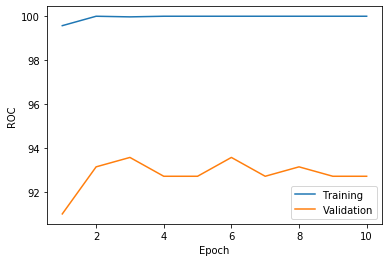

In [24]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()
plt.show()

In [22]:
model.eval()
all_preds = []
all_targets = []

for i, (features,targets) in enumerate(test_dataloader):
    features = features.to(DEVICE)
    logits,probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    all_preds += predicted_labels.tolist()
    all_targets += targets.tolist()

In [23]:
np.mean(np.array(all_preds) == np.array(all_targets))

0.9358974358974359

In [ ]:
model.to("cpu")

In [23]:
compute_accuracy(model, dataset_loader["val"], DEVICE)

tensor(43.9010)

In [30]:
def image2text(model, chars, test_data_transform, image_path):
    img = Image.open(image_path)
    input = torch.unsqueeze(test_data_transform(img),0)    
    logits,probas = model(input)
    _, predicted_idx = torch.max(probas, 1)
    return chars[predicted_idx]
image2text(model,chars,test_data_transform,"cuts/行.png")

'行'

In [31]:
image2text(model,chars,test_data_transform,"cuts/象.png")

'象'

In [32]:
image2text(model,chars,test_data_transform,"cuts/领.png")

'领'

In [33]:
image2text(model,chars,test_data_transform,"cuts/螃.png")

'螃'

In [34]:
image2text(model,chars,test_data_transform,"cuts/蟹.png")

'蟹'